# <center>Problem Statement</center>

### **Description:**

A simple yet challenging project, to estimate the BMI based on the Gender, Height & Weight. The complexity arises due the fact that dataset has less samples, & is highly imbalanced. Can you overcome these obstacles & build a good predictive model to classify them?

This data frame contains the following columns:

Gender : Male / Female

Height : Number (cm)

Weight : Number (Kg)

Index : 0 - Extremely Weak, 1 - Weak, 2 - Normal, 3 - Overweight, 4 - Obesity, 5 - Extreme Obesity

### **Acknowledgements:**

This dataset has been referred from Kaggle.

### **Objective:**

Understand the Dataset & cleanup (if required).
Build classification models to predict various categories of BMI.
Also fine-tune the hyperparameters & compare the evaluation metrics of various classification algorithms.

# 1. Importing Required Libraries

In [1]:
%config Completer.use_jedi = False

In [2]:
# Import Basic Libraries
import os
import math
import scipy
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

# From MatplotLib
import matplotlib.pyplot as plt

# From Scipy 
from scipy.stats import loguniform

# From Sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn import tree
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, classification_report, f1_score

# For SMOTE
from imblearn.over_sampling import SMOTE

import warnings 
warnings.filterwarnings('ignore')

# 2. Data Exploration

In [3]:
df = pd.read_csv('../input/bmidataset/bmi.csv')

labels = ['Extremely Weak','Weak','Normal','Overweight','Obsesity','Extreme Obesity']

MAP={}
for e, i in enumerate(sorted(df["Index"].unique())):
    MAP[i]=labels[e]
    
df["Class"] = df["Index"].map(MAP)

display(df.head())

print(f"The Datset consists of {df.shape[1]} features & {df.shape[0]} samples.")

,Gender,Height,Weight,Index,Class
0,Male,174,96,4,Obsesity
1,Male,189,87,2,Normal
2,Female,185,110,4,Obsesity
3,Female,195,104,3,Overweight
4,Male,149,61,3,Overweight


The Datset consists of 5 features & 500 samples.


In [4]:
# Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  500 non-null    object
 1   Height  500 non-null    int64 
 2   Weight  500 non-null    int64 
 3   Index   500 non-null    int64 
 4   Class   500 non-null    object
dtypes: int64(3), object(2)
memory usage: 19.7+ KB


In [5]:
# Checking number of unique rows in each feature

df.nunique().sort_values()

Gender      2
Index       6
Class       6
Height     60
Weight    110
dtype: int64

In [6]:
# Checking the stats of all the columns

display(df.describe())

,Height,Weight,Index
count,500.000000,500.000000,500.000000
mean,169.944000,106.000000,3.748000
std,16.375261,32.382607,1.355053
min,140.000000,50.000000,0.000000
25%,156.000000,80.000000,3.000000
50%,170.500000,106.000000,4.000000
75%,184.000000,136.000000,5.000000
max,199.000000,160.000000,5.000000


# 3. Exploratory Data Analysis (EDA)

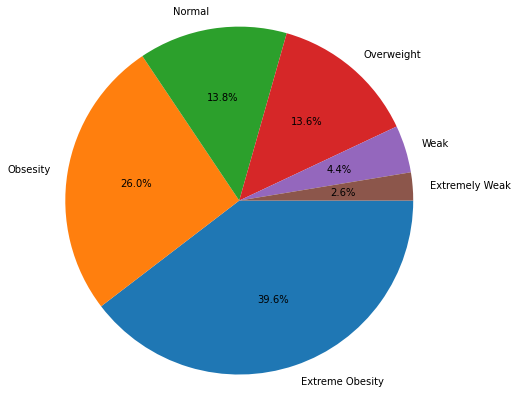

In [7]:
# Let us first analyze the distribution of the target variable

plt.pie(df["Index"].value_counts(), labels=df["Class"].value_counts().index, counterclock=False, autopct='%1.1f%%', radius=2)
plt.show()

The Target Variable seems to be slightly imbalanced! Hence we shall try to perform data augmentation.

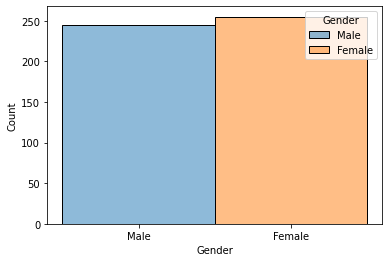

In [8]:
# Visualising the categorical features 

sns.histplot(data=df, x="Gender", hue="Gender")
plt.show()

Visualizing the categorical features reveal lot of information about the dataset.

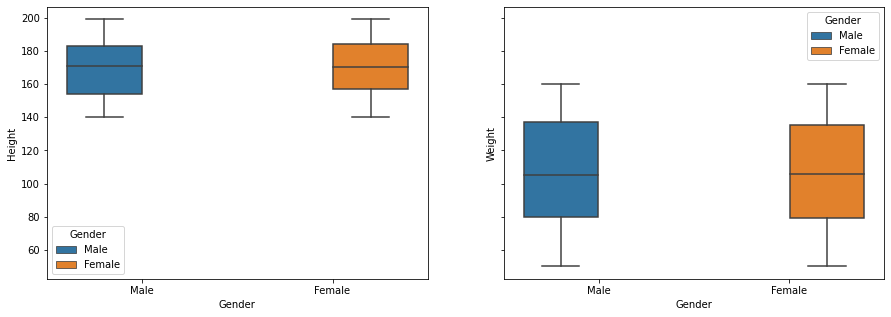

In [9]:
# Visualizing with Box Plot 

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.boxplot(ax=axes[0], data = df, hue="Gender", x = "Gender", y = "Height")

sns.boxplot(ax=axes[1], data = df, hue="Gender", x = "Gender", y = "Weight")

plt.show()

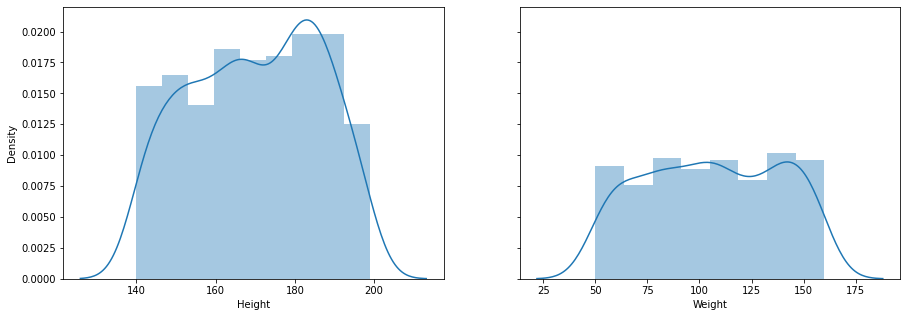

In [10]:
# Visualization with Dist Plot

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.distplot(ax=axes[0], a=df["Height"])
sns.distplot(ax=axes[1], a=df["Weight"])

plt.show()

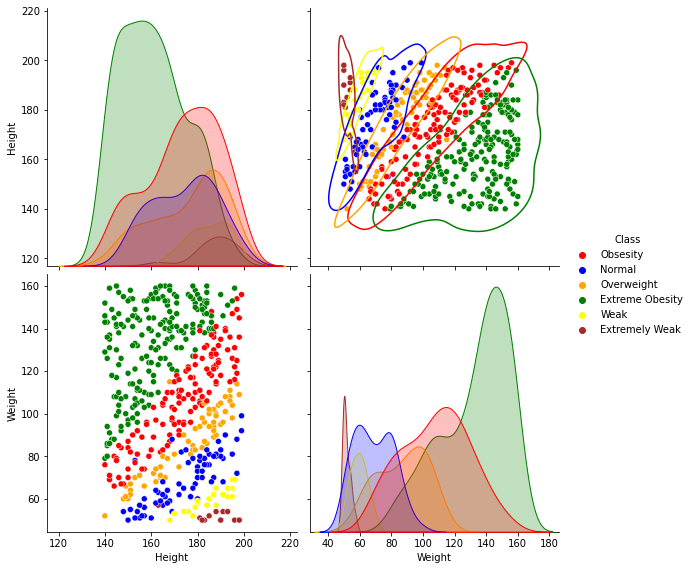

In [11]:
# Visualizing with Pairplot 

colors = ["red", "blue", "orange", "green", "yellow", "brown"]
new_df = df.drop(labels=["Index"], axis=1)

pairplot = sns.pairplot(data=new_df, hue="Class", size=4, palette=colors)
pairplot.map_upper(sns.kdeplot, levels=1, color="1")

plt.show()

The data samples of most of the features do show some patterns. Also they seem to have lot of overlap for the outcome classes, making it difficult to be distingusihable. Let is proceed to perform cleanup on the data to remove the irregularities.

# 3. Data Preprocessing

In [12]:
# Remove Duplicates Entry
r, c = df.shape

df.drop_duplicates(inplace=True)

if(df.shape == (r, c)):
    print("The given set doesn't have any duplicates.")
else:
    print(f"The given dataset is having {r - df.shape[0]} duplicate entries.")

The given dataset is having 11 duplicate entries.


In [13]:
df = df.drop(labels=["Class"], axis=1)
df["Gender"] = np.where(df["Gender"] == "Male", 1, 0)

df.head()

,Gender,Height,Weight,Index
0,1,174,96,4
1,1,189,87,2
2,0,185,110,4
3,0,195,104,3
4,1,149,61,3


In [14]:
X = df.drop(["Index"], axis=1)
Y = df["Index"]

In [15]:
smote = SMOTE()
X, Y = smote.fit_resample(X, Y)

df = pd.DataFrame(X, columns=df.columns)
df["Index"] = Y

print('Class distribution after applying SMOTE Technique: ', Y.value_counts())

Class distribution after applying SMOTE Technique:  4    195
2    195
3    195
5    195
1    195
0    195
Name: Index, dtype: int64


The final dataset after cleanup has 1170 samples & 4 columns.

# 4. Data Manipulation

In [16]:
X = df.drop(["Index"], axis=1)
Y = df["Index"]

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=7)

print('Original set  ---> ', X.shape, Y.shape,
      '\nTraining set  ---> ',x_train.shape, y_train.shape,
      '\nTesting set   ---> ', x_test.shape,'', y_test.shape)

Original set  --->  (1170, 3) (1170,) 
Training set  --->  (936, 3) (936,) 
Testing set   --->  (234, 3)  (234,)


In [17]:
# Feature Scaling (Standardization)

scaler = StandardScaler()

print("\033[1m <-- Standardardization on Training set -->")
x_train_scale = scaler.fit_transform(x_train)
x_train_scale = pd.DataFrame(x_train_scale, columns=X.columns)
display(x_train_scale.head())

print("\033[1m <-- Standardardization on Testing set -->")
x_test_scale = scaler.transform(x_test)
x_test_scale = pd.DataFrame(x_test_scale, columns=X.columns)
display(x_test_scale.head())

 <-- Standardardization on Training set -->


,Gender,Height,Weight
0,-0.746595,-0.587785,1.719697
1,1.339414,0.399947,1.688108
2,-0.746595,-0.587785,1.751285
3,1.339414,1.255982,1.024758
4,-0.746595,0.334098,-0.301943


 <-- Standardardization on Testing set -->


,Gender,Height,Weight
0,1.339414,0.729191,-0.649413
1,1.339414,0.465796,-0.870530
2,1.339414,0.334098,2.098754
3,1.339414,0.926738,-1.091646
4,-0.746595,0.926738,-1.028470


# 5. Model Training and Prediction

In [18]:
# Let us create first create a table to store the results of various models 

Evaluation_Results = pd.DataFrame(np.zeros((5,3)), columns=['Accuracy', 'Precision', 'F1-score'])
Evaluation_Results.index=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Random Forest Classifier (RF)',
                         'Support Vector Machine (SVM)','K Nearest Neighbours (KNN)']
Evaluation_Results

,Accuracy,Precision,F1-score
Logistic Regression (LR),0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0
Support Vector Machine (SVM),0.0,0.0,0.0
K Nearest Neighbours (KNN),0.0,0.0,0.0


In [19]:
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(y_test, pred),3)*100   
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(y_test, pred, average='weighted'),3)*100 
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(y_test, pred, average='weighted'),3)*100 
    
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*2,'-'*15,Evaluation_Results.index[i], '-'*15,'>'*2))
    
    print('Accuracy = {}%'.format(round(accuracy_score(y_test, pred),3)*100))
    print('Precision = {}%'.format(round(precision_score(y_test, pred, average='weighted'),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(y_test, pred, average='weighted'),3)*100))
    
    print('\n \033[1m <-- Confusiton Matrix --> \033[0m\n', confusion_matrix(y_test, pred))
    print('\n \033[1m <-- Classification Report -->\033[0m\n', classification_report(y_test, pred))

## I. Logistic Regression

In [20]:
LR_model = LogisticRegression()

space = {'C': loguniform(1e-5, 100)}

RCV = RandomizedSearchCV(LR_model, space, n_iter=50)

LR = RCV.fit(x_train_scale, y_train).best_estimator_

pred = LR.predict(x_test_scale)
pred_prob = LR.predict_proba(x_test_scale)

Classification_Summary(pred, pred_prob, 0)

<<--------------- Evaluating Logistic Regression (LR) --------------->>

Accuracy = 94.89999999999999%
Precision = 94.89999999999999%
F1 Score = 94.89999999999999%

  <-- Confusiton Matrix --> 
 [[34  0  1  0  0  0]
 [ 3 36  0  0  0  0]
 [ 0  1 36  2  0  0]
 [ 0  0  0 35  2  0]
 [ 0  0  0  1 39  2]
 [ 0  0  0  0  0 42]]

  <-- Classification Report -->
               precision    recall  f1-score   support

           0       0.92      0.97      0.94        35
           1       0.97      0.92      0.95        39
           2       0.97      0.92      0.95        39
           3       0.92      0.95      0.93        37
           4       0.95      0.93      0.94        42
           5       0.95      1.00      0.98        42

    accuracy                           0.95       234
   macro avg       0.95      0.95      0.95       234
weighted avg       0.95      0.95      0.95       234



## II. Decision Tree

In [21]:
# Building Decision Tree Classifier

DT_model = DecisionTreeClassifier()

space = {"max_depth": [3, None], "criterion": ["entropy"]}

RCV = RandomizedSearchCV(DT_model, space, n_iter=50)

DT = RCV.fit(x_train_scale, y_train).best_estimator_

pred = DT.predict(x_test_scale)
pred_prob = DT.predict_proba(x_test_scale)

Classification_Summary(pred,pred_prob,1)

<<--------------- Evaluating Decision Tree Classifier (DT) --------------->>

Accuracy = 93.60000000000001%
Precision = 93.60000000000001%
F1 Score = 93.60000000000001%

  <-- Confusiton Matrix --> 
 [[35  0  0  0  0  0]
 [ 0 39  0  0  0  0]
 [ 0  1 36  2  0  0]
 [ 0  0  0 34  3  0]
 [ 0  0  1  2 35  4]
 [ 0  0  0  0  2 40]]

  <-- Classification Report -->
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.97      1.00      0.99        39
           2       0.97      0.92      0.95        39
           3       0.89      0.92      0.91        37
           4       0.88      0.83      0.85        42
           5       0.91      0.95      0.93        42

    accuracy                           0.94       234
   macro avg       0.94      0.94      0.94       234
weighted avg       0.94      0.94      0.94       234



## III. Random Forest

In [22]:
# Building Random-Forest Classifier

RF_model = RandomForestClassifier()

space = {'bootstrap': [True, False], 'max_depth': [10, 20, 50, None], 'max_features': ['auto', 'sqrt']}

RCV = RandomizedSearchCV(RF_model, space, n_iter=50, scoring='f1_weighted')

RF = RCV.fit(x_train_scale, y_train).best_estimator_

pred = RF.predict(x_test_scale)
pred_prob = RF.predict_proba(x_test_scale)

Classification_Summary(pred, pred_prob, 2)

<<--------------- Evaluating Random Forest Classifier (RF) --------------->>

Accuracy = 95.3%
Precision = 95.5%
F1 Score = 95.3%

  <-- Confusiton Matrix --> 
 [[35  0  0  0  0  0]
 [ 0 39  0  0  0  0]
 [ 0  1 37  1  0  0]
 [ 0  0  0 34  3  0]
 [ 0  0  0  2 39  1]
 [ 0  0  0  0  3 39]]

  <-- Classification Report -->
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.97      1.00      0.99        39
           2       1.00      0.95      0.97        39
           3       0.92      0.92      0.92        37
           4       0.87      0.93      0.90        42
           5       0.97      0.93      0.95        42

    accuracy                           0.95       234
   macro avg       0.96      0.95      0.95       234
weighted avg       0.95      0.95      0.95       234



## IV. Support Vector Machine (SVM)

In [23]:
# Building Support Vector Machine Classifier

SVM_model = SVC(probability=True).fit(x_train_scale, y_train)

param = {
     "C": [.01, .1, 1, 5, 10, 100],             
     "gamma": [.01, .1, 1, 5, 10, 100],
     "kernel": ["rbf"]
}

RCV = RandomizedSearchCV(SVM_model, param, n_iter=50)

SVM = RCV.fit(x_train_scale, y_train).best_estimator_

pred = SVM.predict(x_test_scale)
pred_prob = SVM.predict_proba(x_test_scale)

Classification_Summary(pred, pred_prob,3)

<<--------------- Evaluating Support Vector Machine (SVM) --------------->>

Accuracy = 94.0%
Precision = 94.19999999999999%
F1 Score = 94.0%

  <-- Confusiton Matrix --> 
 [[33  1  1  0  0  0]
 [ 2 37  0  0  0  0]
 [ 0  1 35  3  0  0]
 [ 0  0  0 35  2  0]
 [ 0  0  0  0 41  1]
 [ 0  0  0  0  3 39]]

  <-- Classification Report -->
               precision    recall  f1-score   support

           0       0.94      0.94      0.94        35
           1       0.95      0.95      0.95        39
           2       0.97      0.90      0.93        39
           3       0.92      0.95      0.93        37
           4       0.89      0.98      0.93        42
           5       0.97      0.93      0.95        42

    accuracy                           0.94       234
   macro avg       0.94      0.94      0.94       234
weighted avg       0.94      0.94      0.94       234



## V. K Nearest Neighbours (KNN)

In [24]:
# Building K-Neareset Neighbours Classifier

KNN_model = KNeighborsClassifier()

space = {
    "n_neighbors": [i for i in range(1,30,5)], 
    "weights": ["uniform", "distance"], 
    "algorithm": ["ball_tree", "kd_tree", "brute"]
}

RCV = RandomizedSearchCV(KNN_model, space, n_iter=50)

KNN = RCV.fit(x_train_scale, y_train).best_estimator_

pred = KNN.predict(x_test_scale)
pred_prob = KNN.predict_proba(x_test_scale)

Classification_Summary(pred, pred_prob, 4)

<<--------------- Evaluating K Nearest Neighbours (KNN) --------------->>

Accuracy = 95.7%
Precision = 95.8%
F1 Score = 95.7%

  <-- Confusiton Matrix --> 
 [[34  0  1  0  0  0]
 [ 0 39  0  0  0  0]
 [ 0  2 36  1  0  0]
 [ 0  0  0 36  1  0]
 [ 0  0  0  1 40  1]
 [ 0  0  0  0  3 39]]

  <-- Classification Report -->
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.95      1.00      0.97        39
           2       0.97      0.92      0.95        39
           3       0.95      0.97      0.96        37
           4       0.91      0.95      0.93        42
           5       0.97      0.93      0.95        42

    accuracy                           0.96       234
   macro avg       0.96      0.96      0.96       234
weighted avg       0.96      0.96      0.96       234



# 7. Comparison

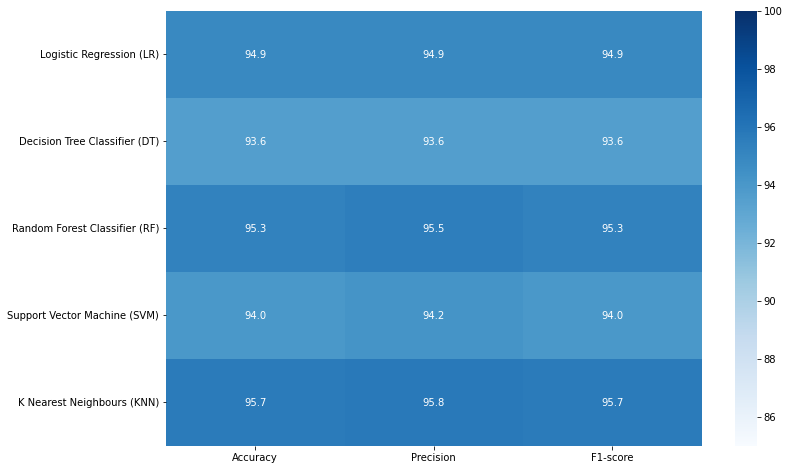

In [25]:
plt.figure(figsize=[12,8])
sns.heatmap(Evaluation_Results, annot=True, vmin=85, vmax=100, cmap='Blues', fmt='.1f')

plt.show()

# 8. Project Outcomes and Conclusion

* The Dataset was quiet small totalling around 500 samples & after preprocessing 0.6% of the datasamples were dropped.
* The samples were slightly imbalanced after processing, hence SMOTE Technique was applied on the data to balance the classes, adding 36.6% more samples to the dataset.
* Visualising the distribution of data & their relationships, helped us to get some insights on the relationship between the feature-set.
* Testing multiple algorithms with fine-tuning hyperparamters gave us some understanding on the model performance for various algorithms on this specific dataset.
* Logistic Regression, Random Forest, SVM and KNN performed exceptionally well on the current dataset, considering F1-Score and Precision as the key-metric.
* Yet it wise to also consider simpler model like Logistic Regression as it is more generalisable & is computationally less expensive, but comes at the cost of slight misclassifications.